In [1]:
%matplotlib inline
import math
import networkx as nx
from matplotlib import pyplot as plt
from plot_utils import plot_snapshot
from synthetic_data import add_p_and_delta, load_data_by_gtype
from ic import make_partial_cascade
from noisy_binary_search import noisy_binary_search

In [56]:
gtype = 'grid'
param = '10'
dumps = load_data_by_gtype(gtype, param)
g = dumps[0]
sp_len = dumps[4]
g = add_p_and_delta(g, 1, 1)
if gtype == 'line':
    pos = [(i, 0) for i in g.nodes()]
elif gtype == 'grid':
    pos = {n: np.array([int(n/10), int(n%10)]) for n in g.nodes()}
else:
    pos = nx.spectral_layout(g)

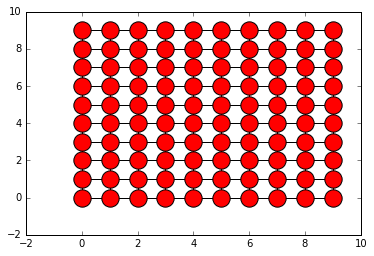

In [57]:
nx.draw_networkx(g, pos=pos, with_labels=False)

In [58]:
source, obs_nodes, infection_times, tree = make_partial_cascade(g, 0.01)

In [43]:
from copy import copy
from ic import sample_graph_from_infection


def median_node(g, mu, sp_len):
    return np.argmin(sp_len @ mu)

def noisy_binary_search(g,
                        source,
                        infection_times,
                        obs_nodes,
                        sp_len,
                        consistency_multiplier,
                        max_iter,
                        sampled_graphs,
                        uninfected_simulation_rounds=100,
                        debug=False,
                        save_log=False):
    """sp_len: 2d array of shortest path length
    """
    # observed from the plot in infection_probability_vs_fraction_of_shortest_path.ipynb
    mu = np.ones(g.number_of_nodes(), dtype=np.float)
    for n in obs_nodes:
        mu[n] = 0

    queried_nodes = copy(obs_nodes)
    queried_nodes_log = []
    mu_log = []

    for i in range(max_iter):
        if debug:
            print('source\'s mu: {:.2f}'.format(mu[source]))

        if len(queried_nodes) == g.number_of_nodes():
            break
        q = median_node(g, mu, sp_len)
        queried_nodes.add(q)

        if save_log:
            queried_nodes_log.append(q)

        if debug:
            print('query node: {}'.format(q))

        # check if q is source
        found_source = True
        for n in g.neighbors_iter(q):
            if infection_times[q] > infection_times[n]:
                found_source = False

        if found_source:
            assert q == source, '{} != {} ({} and {})'.format(
                q, source,
                infection_times[q],
                infection_times[source])
            if save_log:
                mu = np.zeros(g.number_of_nodes())
                mu[source] = 1
                mu_log.append(mu)
            break

        possible_ancestors = []
        # using just one ancestor node
        for n in g.neighbors_iter(q):
            queried_nodes.add(n)
            if save_log:
                # querie_nodes_log.append(n)
                pass
            if infection_times[q] - infection_times[n] == g[n][q]['d']:
                possible_ancestors.append(n)
                break

        if debug:
            print('ancestor nodes: {}'.format(possible_ancestors))

        if len(possible_ancestors) > 0:
            for a in possible_ancestors:
                for n in g.nodes_iter():
                    if sp_len[n, q] == (sp_len[n, a] + g[a][q]['d']):
                        mu[n] *= consistency_multiplier
                    else:
                        mu[n] *= (1 - consistency_multiplier)
        if save_log:
            mu_log.append(copy(mu))

    query_count = len(queried_nodes - obs_nodes)
    if debug:
        print('used {} queries to find the source'.format(query_count))
    if save_log:
        return query_count, queried_nodes_log, mu_log
    else:
        return query_count

In [59]:
query_count, queried_nodes, mu_list = noisy_binary_search(g, source, infection_times, obs_nodes=set(), 
                                                 sampled_graphs=None,
                                                 sp_len=sp_len, consistency_multiplier=1.0,
                                                 max_iter=g.number_of_nodes(),
                                                 debug=True,
                                                 save_log=True)
print('source is {}'.format(source))

source's mu: 1.00
query node: 44
ancestor nodes: [45]
source's mu: 1.00
query node: 47
ancestor nodes: [57]
source's mu: 1.00
query node: 77
ancestor nodes: [76]
source's mu: 1.00
query node: 75
ancestor nodes: [76]
source's mu: 1.00
query node: 76
ancestor nodes: [86]
source's mu: 1.00
query node: 86
used 15 queries to find the source
source is 86


In [61]:
len(mu_list), len(queried_nodes)

(6, 6)

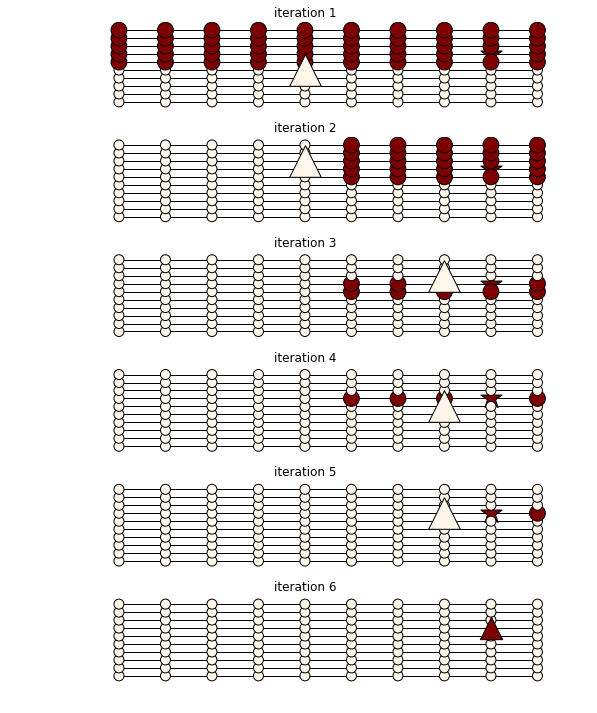

In [60]:
fig, ax = plt.subplots(len(queried_nodes), 1, figsize=(10, 2*len(queried_nodes)))
for i, (q, mu) in enumerate(zip(queried_nodes, mu_list)):
    mu = {i: v for i, v in enumerate(mu)}
    plot_snapshot(g, pos, ax=ax[i], node2weight=mu,
                  source_node=source, query_node=q)
    ax[i].set_title('iteration {}'.format(i+1))
    ax[i].axis('off')